## Notebook purpose

See how it looks when we just do ifft of undersampled k-space for different accel factors

In [2]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import h5py
import torch

sys.path.append('/home/vanveen/ConvDecoder/')
from utils.transform import fft_2d, ifft_2d, root_sum_squares

In [9]:
def plot_list(arr_list):
    
    NUM_COLS = len(arr_list)
    title_list = ['gt', '4x', '8x', '12x']
    
    fig = plt.figure(figsize=(20,20))
    
    for idx in range(NUM_COLS):
        ax = fig.add_subplot(1,NUM_COLS,idx+1)
        ax.imshow(arr_list[idx], cmap='gray')
        ax.set_title(title_list[idx])
        ax.axis('off')

### load sample, mask

In [4]:
ksp = torch.from_numpy(np.load('ksp_3d_samp.npy'))

ksp_vol = ksp[:,:,:,0,:].permute(3,0,1,2) # get echo1, reshape to be (nc, kx, ky, kz)
print(ksp_vol.shape)

idx_kx = ksp_vol.shape[1] // 2
ksp_orig = ksp_vol[:, idx_kx, :, :]

torch.Size([16, 512, 512, 160])


In [5]:
ACCEL_LIST = [4,8,12]

img_list = []

for ACCEL in ACCEL_LIST:
    
    # load mask
    fn_mask = 'mask_poisson_disc_{}x.npy'.format(ACCEL)
    mask = torch.from_numpy(np.load(fn_mask))
    mask = abs(mask).type(torch.uint8)
    idx_y, idx_z = mask.shape[0] // 2, mask.shape[1] // 2
    C=32
    mask[idx_y-C:idx_y+C, idx_z-C:idx_z+C] = 1

    # mask k-space
    ksp_masked = ksp_orig * mask
    img_masked = root_sum_squares(ifft_2d(ksp_masked))

    img_list.append(img_masked)

In [6]:
img_gt = root_sum_squares(ifft_2d(ksp_orig))

img_list.insert(0, img_gt)

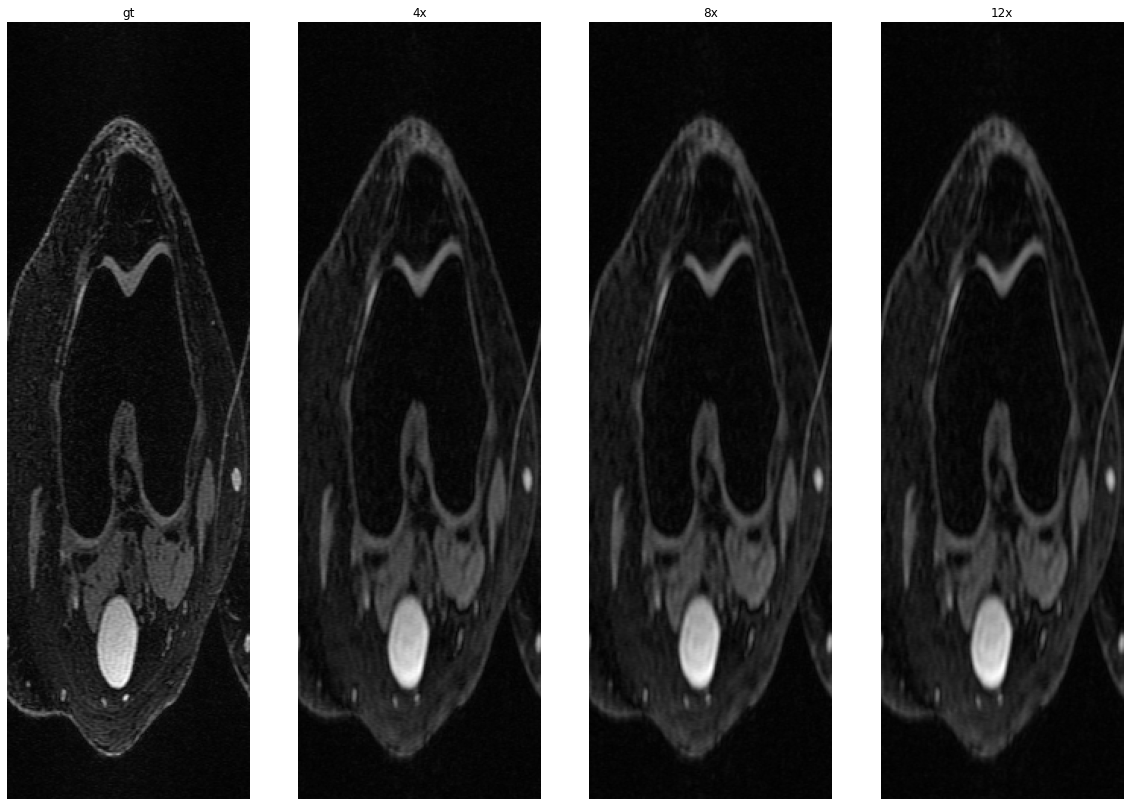

In [10]:
plot_list(img_list)

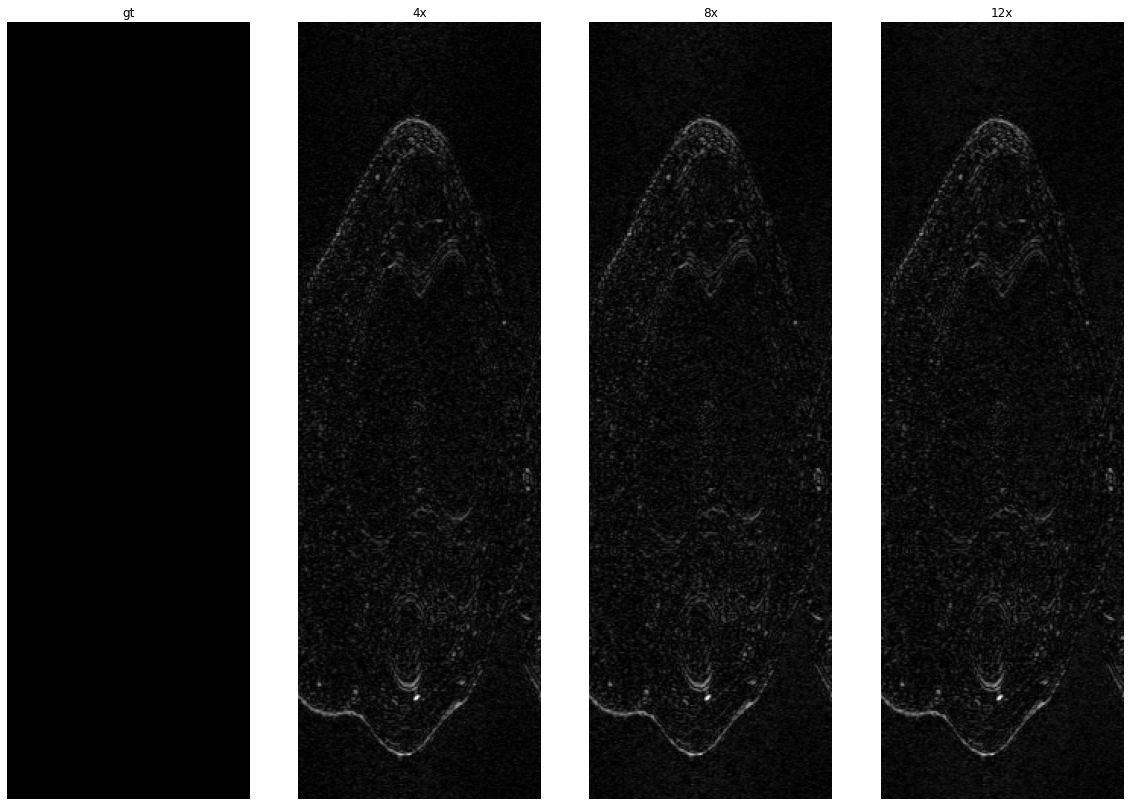

In [13]:
img_diff_list = []

for img in img_list:
    img_diff_list.append(torch.abs(img - img_list[0])) # assuming gt is first element in list
    
plot_list(img_diff_list)